# Example 7: Risk factor optimisation

This example shows how to use factor models to perform optimisations. These reduce the estimation error by modelling asset returns as a function of common risk factors.

In [1]:
using PortfolioOptimisers, PrettyTables
# Format for pretty tables.
tsfmt = (v, i, j) -> begin
    if j == 1
        return Date(v)
    else
        return v
    end
end;
resfmt = (v, i, j) -> begin
    if j == 1
        return v
    else
        return isa(v, Number) ? "$(round(v*100, digits=3)) %" : v
    end
end;
mipresfmt = (v, i, j) -> begin
    if j ∈ (1, 2, 3)
        return v
    else
        return isa(v, Number) ? "$(round(v*100, digits=3)) %" : v
    end
end;
mmtfmt = (v, i, j) -> begin
    if i == j == 1
        return v
    else
        return isa(v, Number) ? "$(round(v*100, digits=3)) %" : v
    end
end;
hmmtfmt = (v, i, j) -> begin
    if i == j == 1
        return v
    else
        return isa(v, Number) ? "$(round(v*100*1e4, digits=2))e-4 %" : v
    end
end;

## 1. ReturnsResult data

We will use the same data as the previous example. But we will also load factor data.

In [2]:
using CSV, TimeSeries, DataFrames

X = TimeArray(CSV.File(joinpath(@__DIR__, "SP500.csv.gz")); timestamp = :Date)[(end - 252):end]
pretty_table(X[(end - 5):end]; formatters = [tsfmt])

F = TimeArray(CSV.File(joinpath(@__DIR__, "Factors.csv.gz")); timestamp = :Date)[(end - 252):end]
pretty_table(F[(end - 5):end]; formatters = [tsfmt])

# Compute the returns
rd = prices_to_returns(X, F)

┌────────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬──────
│  timestamp │    AAPL │     AMD │     BAC │     BBY │     CVX │      GE │     ⋯
│       Date │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Flo ⋯
├────────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼──────
│ 2022-12-20 │ 131.916 │   65.05 │  31.729 │  77.371 │ 169.497 │  62.604 │ 310 ⋯
│ 2022-12-21 │ 135.057 │   67.68 │  32.212 │  78.729 │  171.49 │   64.67 │ 314 ⋯
│ 2022-12-22 │ 131.846 │   63.86 │  31.927 │  78.563 │ 168.918 │  63.727 │ 311 ⋯
│ 2022-12-23 │ 131.477 │   64.52 │  32.005 │  79.432 │  174.14 │  63.742 │ 314 ⋯
│ 2022-12-27 │ 129.652 │   63.27 │  32.065 │   79.93 │ 176.329 │  64.561 │ 314 ⋯
│ 2022-12-28 │ 125.674 │   62.57 │  32.301 │  78.279 │ 173.728 │  63.883 │  31 ⋯
└────────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴──────
                                                              14 columns omitted
┌────────────┬─────────┬────

ReturnsResult
    nx ┼ 20-element Vector{String}
     X ┼ 252×20 Matrix{Float64}
    nf ┼ Vector{String}: ["MTUM", "QUAL", "SIZE", "USMV", "VLUE"]
     F ┼ 252×5 Matrix{Float64}
    ts ┼ 252-element Vector{Date}
    iv ┼ nothing
  ivpa ┴ nothing


## 2. Prior statistics

`PortfolioOptimisers.jl` supports a wide range of prior models. Here we will use four of them:

1. `EmpiricalPrior`: Computes the expected returns vector and covariance matrix from the empirical data.
2. `FactorPrior`: Computes the expected returns vector and covariance matrix using a factor model.
3. `HighOrderPriorEstimator`: Computes the expected returns vector and covariance matrix using the low order prior estimator provided, plus the coskewness and/or cokurtosis using the computed expected returns vector.
4. [`HighOrderFactorPriorEstimator`]-(@ref): Computes the expected returns vector and covariance matrix, plus the coskewness and/or cokurtosis using a factor model.

Priors whos names don't start with the prefix `High` return `LowOrderPrior`, while those that do return `HighOrderPrior` objects.

We have two different regression models with various targets. We won't explore them all in detail here, see `StepwiseRegression` and `DimensionReductionRegression` for details. First let's define the prior estimators.

In [3]:
pes = [EmpiricalPrior(),#
       FactorPrior(),#
       FactorPrior(; re = DimensionReductionRegression()),#
       HighOrderPriorEstimator(),#
       HighOrderPriorEstimator(; pe = FactorPrior()),#
       HighOrderPriorEstimator(; pe = FactorPrior(; re = DimensionReductionRegression())),#
       HighOrderFactorPriorEstimator(;),#
       HighOrderFactorPriorEstimator(;
                                     pe = FactorPrior(;
                                                      re = DimensionReductionRegression()))]

8-element Vector{AbstractPriorEstimator}:
 EmpiricalPrior
       ce ┼ PortfolioOptimisersCovariance
          │   ce ┼ Covariance
          │      │    me ┼ SimpleExpectedReturns
          │      │       │   w ┴ nothing
          │      │    ce ┼ GeneralCovariance
          │      │       │   ce ┼ SimpleCovariance: SimpleCovariance(true)
          │      │       │    w ┴ nothing
          │      │   alg ┴ Full()
          │   mp ┼ DenoiseDetoneAlgMatrixProcessing
          │      │     pdm ┼ Posdef
          │      │         │      alg ┼ UnionAll: NearestCorrelationMatrix.Newton
          │      │         │   kwargs ┴ @NamedTuple{}: NamedTuple()
          │      │      dn ┼ nothing
          │      │      dt ┼ nothing
          │      │     alg ┼ nothing
          │      │   order ┴ DenoiseDetoneAlg()
       me ┼ SimpleExpectedReturns
          │   w ┴ nothing
  horizon ┴ nothing

 FactorPrior
   pe ┼ EmpiricalPrior
      │        ce ┼ PortfolioOptimisersCovariance
      │           │ 

Now let's compute the prior statistics for each estimator.

In [4]:
prs = prior.(pes, rd)

8-element Vector{AbstractPriorResult}:
 LowOrderPrior
        X ┼ 252×20 Matrix{Float64}
       mu ┼ 20-element Vector{Float64}
    sigma ┼ 20×20 Matrix{Float64}
     chol ┼ nothing
        w ┼ nothing
      ens ┼ nothing
      kld ┼ nothing
       ow ┼ nothing
       rr ┼ nothing
     f_mu ┼ nothing
  f_sigma ┼ nothing
      f_w ┴ nothing

 LowOrderPrior
        X ┼ 252×20 Matrix{Float64}
       mu ┼ 20-element Vector{Float64}
    sigma ┼ 20×20 Matrix{Float64}
     chol ┼ 25×20 Transpose{Float64, Matrix{Float64}}
        w ┼ nothing
      ens ┼ nothing
      kld ┼ nothing
       ow ┼ nothing
       rr ┼ Regression
          │   M ┼ 20×5 SubArray{Float64, 2, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, UnitRange{Int64}}, true}
          │   L ┼ 20×5 SubArray{Float64, 2, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, UnitRange{Int64}}, true}
          │   b ┴ 20-element SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}
     f_mu ┼ V

First let's compare the first three prior results.

The expected returns, found in the `mu` field, do not change much between `EmpiricalPrior` and `FactorPrior`. Which illustrates one of the reasons why it's unwise to put much stock on expected returns estimates, since they are highly uncertain and sensitive to noise. We will explore different expected returns estimators, which attempt to improve this drawback in future examples.

In [5]:
pretty_table(DataFrame("Assets" => rd.nx, "EmpiricalPrior" => prs[1].mu,
                       "FactorPrior(Step)" => prs[2].mu,
                       "FactorPrior(DimRed)" => prs[3].mu); formatters = [mmtfmt],
             title = "Expected returns",
             source_notes = "prs[1].mu ≈ prs[1].mu ≈ prs[3].mu: $(prs[1].mu ≈ prs[1].mu ≈ prs[3].mu)")

                          Expected returns
┌────────┬────────────────┬───────────────────┬─────────────────────┐
│ Assets │ EmpiricalPrior │ FactorPrior(Step) │ FactorPrior(DimRed) │
│ String │        Float64 │           Float64 │             Float64 │
├────────┼────────────────┼───────────────────┼─────────────────────┤
│   AAPL │       -0.113 % │          -0.113 % │            -0.113 % │
│    AMD │       -0.281 % │          -0.281 % │            -0.281 % │
│    BAC │       -0.093 % │          -0.093 % │            -0.093 % │
│    BBY │       -0.028 % │          -0.028 % │            -0.028 % │
│    CVX │        0.195 % │           0.195 % │             0.195 % │
│     GE │       -0.034 % │          -0.034 % │            -0.034 % │
│     HD │       -0.071 % │          -0.071 % │            -0.071 % │
│    JNJ │        0.031 % │           0.031 % │             0.031 % │
│    JPM │       -0.042 % │          -0.042 % │            -0.042 % │
│     KO │         0.05 % │            0.05 % │

However, the covariance estimates, found in the `sigma` field, differ significantly more. Factor models tend to produce more stable and robust covariance estimates by capturing the underlying risk factors driving asset returns, while reducing the impact of idiosyncratic noise. We will check the condition number of the covariance matrices to illustrate this. The lower the condition number, the more less noisy and therefore more numerically stable the matrix is.

For the covariance estimation in particular, we can take advantage of a sparser Cholesky decomposition with better numerical properties than the naive version. If present, it is used instead of the cholesky decomposition of `sigma` in the `SecondOrderCone` constraint of the variance and/or standard deviation formulations in traditional optimisations. This special decomposition can be found in the `chol` field of the prior result.

In [6]:
using LinearAlgebra

pretty_table(DataFrame([rd.nx prs[1].sigma], ["Assets"; rd.nx]); formatters = [mmtfmt],
             title = "EmpiricalPrior Covariance",
             source_notes = "Condition number EmpiricalPrior: $(round(cond(prs[1].sigma); digits = 3))")
pretty_table(DataFrame([rd.nx prs[2].sigma], ["Assets"; rd.nx]); formatters = [mmtfmt],
             title = "FactorPrior(Step) Covariance",
             source_notes = "Condition number FactorPrior(Step): $(round(cond(prs[2].sigma); digits = 3))")
pretty_table(DataFrame([rd.nx prs[3].sigma], ["Assets"; rd.nx]); formatters = [mmtfmt],
             title = "FactorPrior(DimRed) Covariance",
             source_notes = "Condition number FactorPrior(DimRed): $(round(cond(prs[3].sigma); digits = 3))")

                           EmpiricalPrior Covariance
┌────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬──────────
│ Assets │    AAPL │     AMD │     BAC │     BBY │     CVX │      GE │      HD ⋯
│    Any │     Any │     Any │     Any │     Any │     Any │     Any │     Any ⋯
├────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼──────────
│   AAPL │  0.05 % │ 0.063 % │ 0.026 % │ 0.034 % │ 0.014 % │ 0.027 % │ 0.026 % ⋯
│    AMD │ 0.063 % │ 0.147 % │ 0.044 % │ 0.057 % │ 0.025 % │ 0.049 % │ 0.039 % ⋯
│    BAC │ 0.026 % │ 0.044 % │ 0.042 % │ 0.026 % │ 0.015 % │ 0.028 % │ 0.017 % ⋯
│    BBY │ 0.034 % │ 0.057 % │ 0.026 % │ 0.081 % │ 0.013 % │ 0.027 % │ 0.037 % ⋯
│    CVX │ 0.014 % │ 0.025 % │ 0.015 % │ 0.013 % │ 0.043 % │ 0.017 % │ 0.007 % ⋯
│     GE │ 0.027 % │ 0.049 % │ 0.028 % │ 0.027 % │ 0.017 % │ 0.048 % │ 0.017 % ⋯
│     HD │ 0.026 % │ 0.039 % │ 0.017 % │ 0.037 % │ 0.007 % │ 0.017 % │ 0.039 % ⋯
│    JNJ │ 0.009 % │ 0.008 % │ 0.007 % │ 0.009 % │ 0.003

The next three prior results have the same low order moments and adjusted returns series as the `i-3`'th prior result because they use the same regression model.

In [7]:
for i in 4:6
    println("prs[$(i-3)].X     == prs[$(i)].X    : $(prs[i-3].X == prs[i].X)")
    println("prs[$(i-3)].mu    == prs[$(i)].mu   : $(prs[i-3].mu == prs[i].mu)")
    println("prs[$(i-3)].sigma == prs[$(i)].sigma: $(prs[i-3].sigma == prs[i].sigma)\n")
end

prs[1].X     == prs[4].X    : true
prs[1].mu    == prs[4].mu   : true
prs[1].sigma == prs[4].sigma: true

prs[2].X     == prs[5].X    : true
prs[2].mu    == prs[5].mu   : true
prs[2].sigma == prs[5].sigma: true

prs[3].X     == prs[6].X    : true
prs[3].mu    == prs[6].mu   : true
prs[3].sigma == prs[6].sigma: true



However, all high order moments for these estimators are identical to each other despite their low order moments being computed differently. This is because they are computed from the prior returns matrix, not the posterior one, as this would be inconsistent. The coskewness matrix is found in the `sk` field, the negative spectral decomposition of its slices is found in the `V` field, and the cokurtosis matrix is found in the `kt` field.

In [8]:
println("prs[4].sk == prs[5].sk == prs[6].sk: $(prs[4].sk == prs[5].sk == prs[6].sk)")
println("prs[4].V  == prs[5].V  == prs[6].V : $(prs[4].V == prs[5].V == prs[6].V)")
println("prs[4].kt == prs[5].kt == prs[6].kt: $(prs[4].kt == prs[5].kt == prs[6].kt)\n")

prs[4].sk == prs[5].sk == prs[6].sk: true
prs[4].V  == prs[5].V  == prs[6].V : true
prs[4].kt == prs[5].kt == prs[6].kt: true



Now let's compare the last four prior results. Remember the last two also use a factor model for the high order moments

In [9]:
for i in 5:7
    for j in 6:8
        if i >= j
            continue
        end
        println("prs[$i].mu    == prs[$j].mu   : $(prs[i].mu == prs[j].mu)")
        println("prs[$i].sigma == prs[$j].sigma: $(prs[i].sigma == prs[j].sigma)")
        println("prs[$i].sk    == prs[$j].sk   : $(prs[i].sk == prs[j].sk)")
        println("prs[$i].V     == prs[$j].V    : $(prs[i].V == prs[j].V)")
        println("prs[$i].kt    == prs[$j].kt   : $(prs[i].kt == prs[j].kt)\n")
    end
end

prs[5].mu    == prs[6].mu   : false
prs[5].sigma == prs[6].sigma: false
prs[5].sk    == prs[6].sk   : true
prs[5].V     == prs[6].V    : true
prs[5].kt    == prs[6].kt   : true

prs[5].mu    == prs[7].mu   : true
prs[5].sigma == prs[7].sigma: true
prs[5].sk    == prs[7].sk   : false
prs[5].V     == prs[7].V    : false
prs[5].kt    == prs[7].kt   : false

prs[5].mu    == prs[8].mu   : false
prs[5].sigma == prs[8].sigma: false
prs[5].sk    == prs[8].sk   : false
prs[5].V     == prs[8].V    : false
prs[5].kt    == prs[8].kt   : false

prs[6].mu    == prs[7].mu   : false
prs[6].sigma == prs[7].sigma: false
prs[6].sk    == prs[7].sk   : false
prs[6].V     == prs[7].V    : false
prs[6].kt    == prs[7].kt   : false

prs[6].mu    == prs[8].mu   : true
prs[6].sigma == prs[8].sigma: true
prs[6].sk    == prs[8].sk   : false
prs[6].V     == prs[8].V    : false
prs[6].kt    == prs[8].kt   : false

prs[7].mu    == prs[8].mu   : false
prs[7].sigma == prs[8].sigma: false
prs[7].sk    == prs[8].sk   : 

As expected, the higher moments are the same only for `prs[5]` and `prs[6]`, since neither of them adjust the higher moments using a factor model. However, their low order moments differ because they use different regression models. The low order moments of `prs[5]` and `prs[7]` use the `StepwiseRegression` model, while `prs[6]` and `prs[8]` use the `DimensionReductionRegression` model, so those match too. Aside from `prs[5]` and `prs[6]`, the higher order moments are computed using regression models.

Let's compare what these higher order moments look like. First let's create the names for the higher order moments.

In [10]:
nx2 = collect(Iterators.flatten([(nx * "_") .* rd.nx for nx in rd.nx]))

400-element Vector{String}:
 "AAPL_AAPL"
 "AAPL_AMD"
 "AAPL_BAC"
 "AAPL_BBY"
 "AAPL_CVX"
 "AAPL_GE"
 "AAPL_HD"
 "AAPL_JNJ"
 "AAPL_JPM"
 "AAPL_KO"
 ⋮
 "XOM_MRK"
 "XOM_MSFT"
 "XOM_PEP"
 "XOM_PFE"
 "XOM_PG"
 "XOM_RRC"
 "XOM_UNH"
 "XOM_WMT"
 "XOM_XOM"

Now let's examine what the coskewness and its negative spectral slices look like.

In [11]:
pretty_table(DataFrame([rd.nx prs[4].sk], ["Assets^2 / Assets"; nx2]);
             formatters = [hmmtfmt], title = "HighOrderPriorEstimator Coskewness",
             source_notes = "Condition number HighOrderPriorEstimator: $(round(cond(prs[4].sk); digits = 3))")
pretty_table(DataFrame([rd.nx prs[7].sk], ["Assets^2 / Assets"; nx2]);
             formatters = [hmmtfmt],
             title = "HighOrderFactorPriorEstimator(Step) Coskewness",
             source_notes = "Condition number HighOrderFactorPriorEstimator(Step): $(round(cond(prs[7].sk); digits = 3))")
pretty_table(DataFrame([rd.nx prs[8].sk], ["Assets^2 / Assets"; nx2]);
             formatters = [hmmtfmt],
             title = "HighOrderFactorPriorEstimator(DimRed) Coskewness",
             source_notes = "Condition number HighOrderFactorPriorEstimator(DimRed): $(round(cond(prs[8].sk); digits = 3))")

pretty_table(DataFrame([rd.nx prs[4].V], ["Assets"; rd.nx]); formatters = [hmmtfmt],
             title = "HighOrderPriorEstimator Coskewness Negative Spectral Slices",
             source_notes = "Condition number HighOrderPriorEstimator: $(round(cond(prs[4].V); digits = 3))")
pretty_table(DataFrame([rd.nx prs[7].V], ["Assets"; rd.nx]); formatters = [hmmtfmt],
             title = "HighOrderFactorPriorEstimator(Step) Coskewness Negative Spectral Slices",
             source_notes = "Condition number HighOrderFactorPriorEstimator(Step): $(round(cond(prs[7].V); digits = 3))")
pretty_table(DataFrame([rd.nx prs[8].V], ["Assets"; rd.nx]); formatters = [hmmtfmt],
             title = "HighOrderFactorPriorEstimator(DimRed) Coskewness Negative Spectral Slices",
             source_notes = "Condition number HighOrderFactorPriorEstimator(DimRed): $(round(cond(prs[8].V); digits = 3))")

                       HighOrderPriorEstimator Coskewness
┌───────────────────┬────────────┬────────────┬────────────┬────────────┬───────
│ Assets^2 / Assets │  AAPL_AAPL │   AAPL_AMD │   AAPL_BAC │   AAPL_BBY │   AA ⋯
│               Any │        Any │        Any │        Any │        Any │      ⋯
├───────────────────┼────────────┼────────────┼────────────┼────────────┼───────
│              AAPL │  3.67e-4 % │  4.74e-4 % │  1.96e-4 % │  0.28e-4 % │ -0.7 ⋯
│               AMD │  4.74e-4 % │  6.48e-4 % │  2.01e-4 % │  1.36e-4 % │ -0.8 ⋯
│               BAC │  1.96e-4 % │  2.01e-4 % │   2.1e-4 % │ -0.03e-4 % │  0.4 ⋯
│               BBY │  0.28e-4 % │  1.36e-4 % │ -0.03e-4 % │ -1.83e-4 % │ -1.5 ⋯
│               CVX │ -0.75e-4 % │ -0.88e-4 % │  0.41e-4 % │ -1.52e-4 % │  0.7 ⋯
│                GE │  0.06e-4 % │ -0.83e-4 % │   0.2e-4 % │ -0.49e-4 % │ -1.1 ⋯
│                HD │  1.89e-4 % │  3.71e-4 % │  0.78e-4 % │ -0.41e-4 % │  -0. ⋯
│               JNJ │ -0.09e-4 % │ -0.39e-4 % │   0

And the cokurtosis.

In [12]:
pretty_table(DataFrame([nx2 prs[4].kt], ["Assets^2"; nx2]); formatters = [hmmtfmt],
             title = "HighOrderPriorEstimator Cokurtosis",
             source_notes = "Condition number HighOrderPriorEstimator: $(round(cond(prs[4].kt); digits = 3))")
pretty_table(DataFrame([nx2 prs[7].kt], ["Assets^2"; nx2]); formatters = [hmmtfmt],
             title = "HighOrderFactorPriorEstimator(Step) Cokurtosis",
             source_notes = "Condition number HighOrderFactorPriorEstimator(Step): $(round(cond(prs[7].kt); digits = 3))")
pretty_table(DataFrame([nx2 prs[8].kt], ["Assets^2"; nx2]); formatters = [hmmtfmt],
             title = "HighOrderFactorPriorEstimator(DimRed) Cokurtosis",
             source_notes = "Condition number HighOrderFactorPriorEstimator(DimRed): $(round(cond(prs[8].kt); digits = 3))")

                       HighOrderPriorEstimator Cokurtosis
┌───────────┬───────────┬───────────┬───────────┬───────────┬───────────┬───────
│  Assets^2 │ AAPL_AAPL │  AAPL_AMD │  AAPL_BAC │  AAPL_BBY │  AAPL_CVX │   AA ⋯
│       Any │       Any │       Any │       Any │       Any │       Any │      ⋯
├───────────┼───────────┼───────────┼───────────┼───────────┼───────────┼───────
│ AAPL_AAPL │ 1.01e-4 % │ 1.17e-4 % │ 0.45e-4 % │ 0.67e-4 % │ 0.19e-4 % │ 0.46 ⋯
│  AAPL_AMD │ 1.17e-4 % │ 1.85e-4 % │ 0.61e-4 % │ 0.88e-4 % │ 0.35e-4 % │ 0.64 ⋯
│  AAPL_BAC │ 0.45e-4 % │ 0.61e-4 % │ 0.35e-4 % │ 0.33e-4 % │ 0.15e-4 % │ 0.27 ⋯
│  AAPL_BBY │ 0.67e-4 % │ 0.88e-4 % │ 0.33e-4 % │  0.7e-4 % │ 0.17e-4 % │ 0.34 ⋯
│  AAPL_CVX │ 0.19e-4 % │ 0.35e-4 % │ 0.15e-4 % │ 0.17e-4 % │  0.3e-4 % │ 0.16 ⋯
│   AAPL_GE │ 0.46e-4 % │ 0.64e-4 % │ 0.27e-4 % │ 0.34e-4 % │ 0.16e-4 % │ 0.41 ⋯
│   AAPL_HD │ 0.65e-4 % │ 0.86e-4 % │ 0.31e-4 % │ 0.53e-4 % │ 0.13e-4 % │  0.3 ⋯
│  AAPL_JNJ │ 0.19e-4 % │ 0.22e-4 % │  0.1e-4 % │ 0

Ideally, the condition numbers of the higher order moments should be lower when using factor models, indicating more stable and robust estimates. However, this is not always the case due to the higher exponentiation involved in their computation.

## 3. Comparing optimisations

We'll now compare the effect of using these different prior estimators in the shape of the efficient frontier. We'll use Clarabel as the solver.

In [13]:
using Clarabel
slv = [Solver(; name = :clarabel2, solver = Clarabel.Optimizer,
              settings = Dict("verbose" => false)),
       Solver(; name = :clarabel2, solver = Clarabel.Optimizer,
              settings = Dict("verbose" => false, "max_step_fraction" => 0.95)),
       Solver(; name = :clarabel2, solver = Clarabel.Optimizer,
              settings = Dict("verbose" => false, "max_step_fraction" => 0.9)),
       Solver(; name = :clarabel2, solver = Clarabel.Optimizer,
              settings = Dict("verbose" => false, "max_step_fraction" => 0.85)),
       Solver(; name = :clarabel2, solver = Clarabel.Optimizer,
              settings = Dict("verbose" => false, "max_step_fraction" => 0.8)),
       Solver(; name = :clarabel2, solver = Clarabel.Optimizer,
              settings = Dict("verbose" => false, "max_step_fraction" => 0.75)),
       Solver(; name = :clarabel2, solver = Clarabel.Optimizer,
              settings = Dict("verbose" => false, "max_step_fraction" => 0.7))]

7-element Vector{Solver{Symbol, UnionAll, T3, @NamedTuple{}, Bool} where T3}:
 Solver
         name ┼ Symbol: :clarabel2
       solver ┼ UnionAll: Clarabel.MOIwrapper.Optimizer
     settings ┼ Dict{String, Bool}: Dict{String, Bool}("verbose" => 0)
    check_sol ┼ @NamedTuple{}: NamedTuple()
  add_bridges ┴ Bool: true

 Solver
         name ┼ Symbol: :clarabel2
       solver ┼ UnionAll: Clarabel.MOIwrapper.Optimizer
     settings ┼ Dict{String, Real}: Dict{String, Real}("verbose" => false, "max_step_fraction" => 0.95)
    check_sol ┼ @NamedTuple{}: NamedTuple()
  add_bridges ┴ Bool: true

 Solver
         name ┼ Symbol: :clarabel2
       solver ┼ UnionAll: Clarabel.MOIwrapper.Optimizer
     settings ┼ Dict{String, Real}: Dict{String, Real}("verbose" => false, "max_step_fraction" => 0.9)
    check_sol ┼ @NamedTuple{}: NamedTuple()
  add_bridges ┴ Bool: true

 Solver
         name ┼ Symbol: :clarabel2
       solver ┼ UnionAll: Clarabel.MOIwrapper.Optimizer
     settings ┼ Dict{String, Rea

### 3.1 Mean-Standard deviation optimisation

First let's examine the mean-standard deviation efficient frontier using the empirical and factor priors. We will compute the efficient fronteir with 50 points for all relevant priors.

In [14]:
# JuMP Optimsiers, we will compute the efficient frontier with 50 points for all of them.
opts = [JuMPOptimiser(; pr = prs[1], slv = slv,
                      ret = ArithmeticReturn(; lb = Frontier(; N = 50))),
        JuMPOptimiser(; pr = prs[2], slv = slv,
                      ret = ArithmeticReturn(; lb = Frontier(; N = 50))),
        JuMPOptimiser(; pr = prs[3], slv = slv,
                      ret = ArithmeticReturn(; lb = Frontier(; N = 50)))]

# Mean-Risk estimators using the standard deviation.
mrs = [MeanRisk(; r = StandardDeviation(), obj = MinimumRisk(), opt = opt) for opt in opts]

# Optimise
ress = optimise.(mrs)

3-element Vector{MeanRiskResult{DataType, T2, Vector{OptimisationReturnCode}, Vector{JuMPOptimisationSolution}, JuMP.Model, Nothing} where T2}:
 MeanRiskResult
       oe ┼ DataType: DataType
       pa ┼ ProcessedJuMPOptimiserAttributes
          │       pr ┼ LowOrderPrior
          │          │         X ┼ 252×20 Matrix{Float64}
          │          │        mu ┼ 20-element Vector{Float64}
          │          │     sigma ┼ 20×20 Matrix{Float64}
          │          │      chol ┼ nothing
          │          │         w ┼ nothing
          │          │       ens ┼ nothing
          │          │       kld ┼ nothing
          │          │        ow ┼ nothing
          │          │        rr ┼ nothing
          │          │      f_mu ┼ nothing
          │          │   f_sigma ┼ nothing
          │          │       f_w ┴ nothing
          │       wb ┼ WeightBounds
          │          │   lb ┼ 20-element StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int6

Let's plot the efficient frontiers.

In [15]:
using GraphRecipes, StatsPlots

Empirical prior composition.

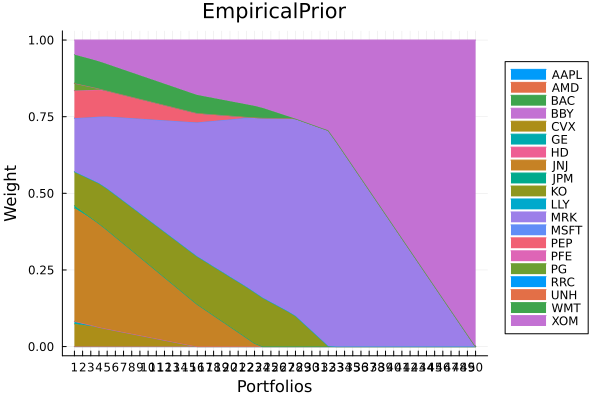

In [16]:
plot_stacked_area_composition(ress[1].w, rd.nx;
                              kwargs = (; xlabel = "Portfolios", ylabel = "Weight",
                                        title = "EmpiricalPrior", legend = :outerright))

Empirical prior frontier.

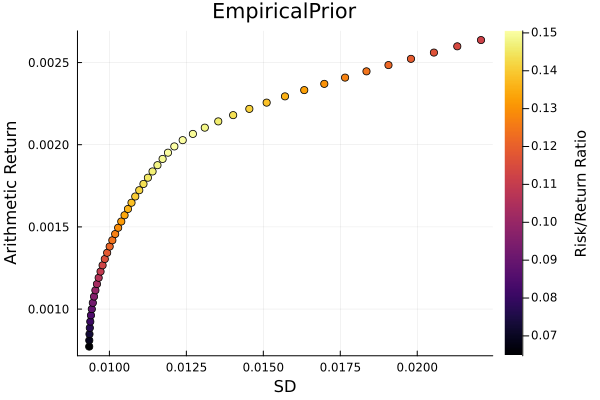

In [17]:
r = StandardDeviation()
plot_measures(ress[1].w, prs[1]; x = r, y = ReturnRiskMeasure(; rt = ress[1].ret),
              c = ReturnRiskRatioRiskMeasure(; rt = ress[1].ret, rk = r,
                                             rf = 4.2 / 100 / 252),
              title = "EmpiricalPrior", xlabel = "SD", ylabel = "Arithmetic Return",
              colorbar_title = "\nRisk/Return Ratio", right_margin = 6Plots.mm)

Factor prior composition with stepwise regression.

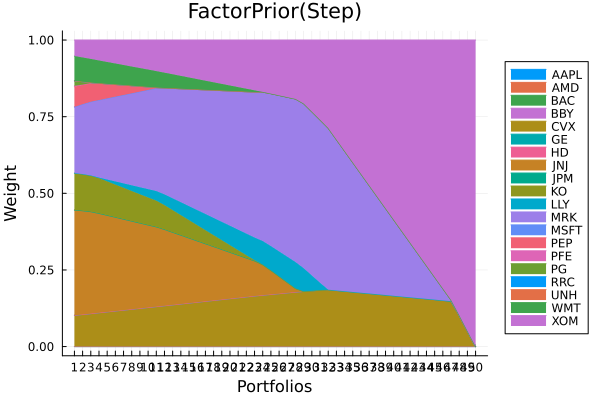

In [18]:
plot_stacked_area_composition(ress[2].w, rd.nx;
                              kwargs = (; xlabel = "Portfolios", ylabel = "Weight",
                                        title = "FactorPrior(Step)", legend = :outerright))

Factor prior frontier with stepwise regression.

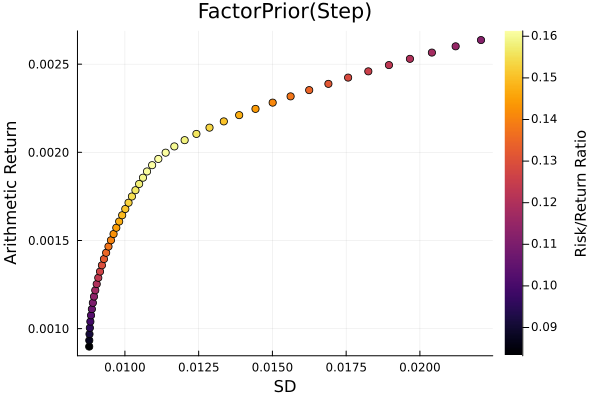

In [19]:
r = StandardDeviation()
plot_measures(ress[2].w, prs[2]; x = r, y = ReturnRiskMeasure(; rt = ress[2].ret),
              c = ReturnRiskRatioRiskMeasure(; rt = ress[2].ret, rk = r,
                                             rf = 4.2 / 100 / 252),
              title = "FactorPrior(Step)", xlabel = "SD", ylabel = "Arithmetic Return",
              colorbar_title = "\nRisk/Return Ratio", right_margin = 6Plots.mm)

Factor prior using dimensionality reduction.

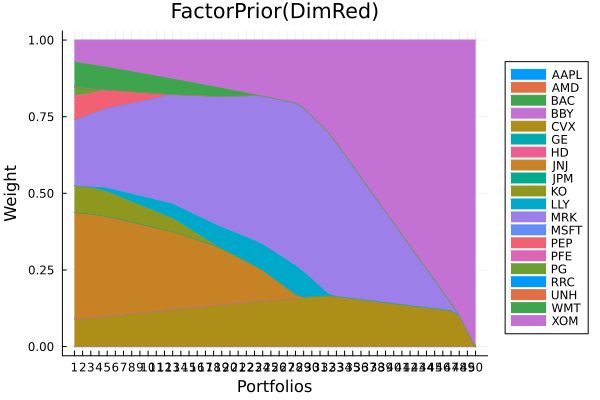

In [20]:
plot_stacked_area_composition(ress[3].w, rd.nx;
                              kwargs = (; xlabel = "Portfolios", ylabel = "Weight",
                                        title = "FactorPrior(DimRed)",
                                        legend = :outerright))

Factor prior frontier with stepwise regression.

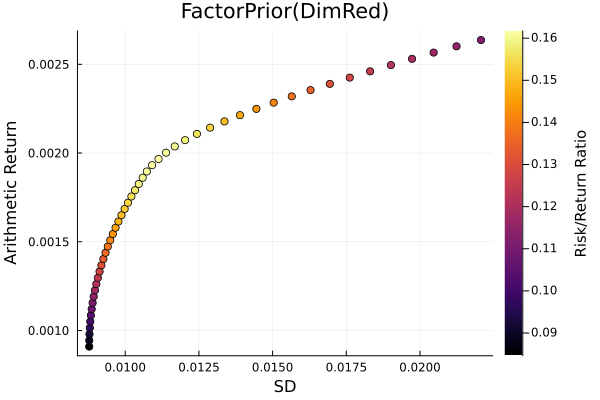

In [21]:
r = StandardDeviation()
plot_measures(ress[3].w, prs[3]; x = r, y = ReturnRiskMeasure(; rt = ress[3].ret),
              c = ReturnRiskRatioRiskMeasure(; rt = ress[3].ret, rk = r,
                                             rf = 4.2 / 100 / 252),
              title = "FactorPrior(DimRed)", xlabel = "SD", ylabel = "Arithmetic Return",
              colorbar_title = "\nRisk/Return Ratio", right_margin = 6Plots.mm)

Let's optimise the maximum risk-adjusted return ratio of the three to see how a single portfolio differs.

In [22]:
opts = [JuMPOptimiser(; pr = prs[1], slv = slv), JuMPOptimiser(; pr = prs[2], slv = slv),
        JuMPOptimiser(; pr = prs[3], slv = slv)]

# Mean-Risk estimators using the standard deviation.
mrs = [MeanRisk(; r = StandardDeviation(), obj = MaximumRatio(; rf = 4.2 / 100 / 252),
                opt = opt) for opt in opts]

# Optimise
ress = optimise.(mrs)
pretty_table(DataFrame("Assets" => rd.nx, "EmpiricalPrior" => ress[1].w,
                       "FactorPrior(Step)" => ress[2].w,
                       "FactorPrior(DimRed)" => ress[3].w); formatters = [resfmt])

┌────────┬────────────────┬───────────────────┬─────────────────────┐
│ Assets │ EmpiricalPrior │ FactorPrior(Step) │ FactorPrior(DimRed) │
│ String │        Float64 │           Float64 │             Float64 │
├────────┼────────────────┼───────────────────┼─────────────────────┤
│   AAPL │          0.0 % │             0.0 % │               0.0 % │
│    AMD │          0.0 % │             0.0 % │               0.0 % │
│    BAC │          0.0 % │             0.0 % │               0.0 % │
│    BBY │          0.0 % │             0.0 % │               0.0 % │
│    CVX │          0.0 % │          18.328 % │            16.403 % │
│     GE │          0.0 % │             0.0 % │               0.0 % │
│     HD │          0.0 % │             0.0 % │               0.0 % │
│    JNJ │          0.0 % │             0.0 % │               0.0 % │
│    JPM │          0.0 % │             0.0 % │               0.0 % │
│     KO │          0.0 % │             0.0 % │               0.0 % │
│    LLY │          

We can see that the factor model portfolios are more diversified than the empirical one. This is because the factor model reduces estimation error in the covariance matrix, leading to more stable and diversified portfolios.

### 3.2 Mean-NegativeSkewness optimisation

Here we will perform the exact same procedure as before, but using the negative skewness as the risk measure.

In [23]:
# JuMP Optimsiers, we will compute the efficient frontier with 50 points for all of them.
opts = [JuMPOptimiser(; pr = prs[4], slv = slv,
                      ret = ArithmeticReturn(; lb = Frontier(; N = 50))),
        JuMPOptimiser(; pr = prs[7], slv = slv,
                      ret = ArithmeticReturn(; lb = Frontier(; N = 50))),
        JuMPOptimiser(; pr = prs[8], slv = slv,
                      ret = ArithmeticReturn(; lb = Frontier(; N = 50)))]

# Mean-Risk estimators using the standard deviation.
mrs = [MeanRisk(; r = NegativeSkewness(), obj = MinimumRisk(), opt = opt) for opt in opts]

# Optimise
ress = optimise.(mrs)

3-element Vector{MeanRiskResult{DataType, T2, Vector{OptimisationReturnCode}, Vector{JuMPOptimisationSolution}, JuMP.Model, Nothing} where T2}:
 MeanRiskResult
       oe ┼ DataType: DataType
       pa ┼ ProcessedJuMPOptimiserAttributes
          │       pr ┼ HighOrderPrior
          │          │     pr ┼ LowOrderPrior
          │          │        │         X ┼ 252×20 Matrix{Float64}
          │          │        │        mu ┼ 20-element Vector{Float64}
          │          │        │     sigma ┼ 20×20 Matrix{Float64}
          │          │        │      chol ┼ nothing
          │          │        │         w ┼ nothing
          │          │        │       ens ┼ nothing
          │          │        │       kld ┼ nothing
          │          │        │        ow ┼ nothing
          │          │        │        rr ┼ nothing
          │          │        │      f_mu ┼ nothing
          │          │        │   f_sigma ┼ nothing
          │          │        │       f_w ┴ nothing
        

Let's plot the efficient frontiers.

Empirical prior composition.

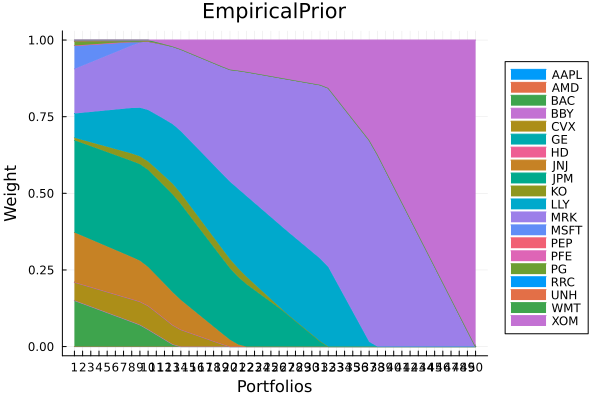

In [24]:
plot_stacked_area_composition(ress[1].w, rd.nx;
                              kwargs = (; xlabel = "Portfolios", ylabel = "Weight",
                                        title = "EmpiricalPrior", legend = :outerright))

Empirical prior frontier.

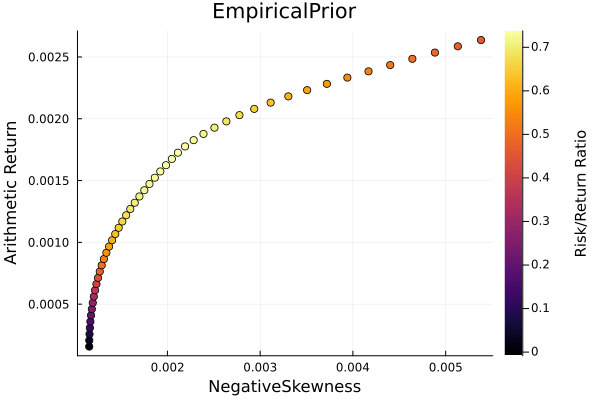

In [25]:
r = NegativeSkewness()
plot_measures(ress[1].w, prs[4]; x = r, y = ReturnRiskMeasure(; rt = ress[1].ret),
              c = ReturnRiskRatioRiskMeasure(; rt = ress[1].ret, rk = r,
                                             rf = 4.2 / 100 / 252),
              title = "EmpiricalPrior", xlabel = "NegativeSkewness",
              ylabel = "Arithmetic Return", colorbar_title = "\nRisk/Return Ratio",
              right_margin = 6Plots.mm)

Factor prior composition with stepwise regression.

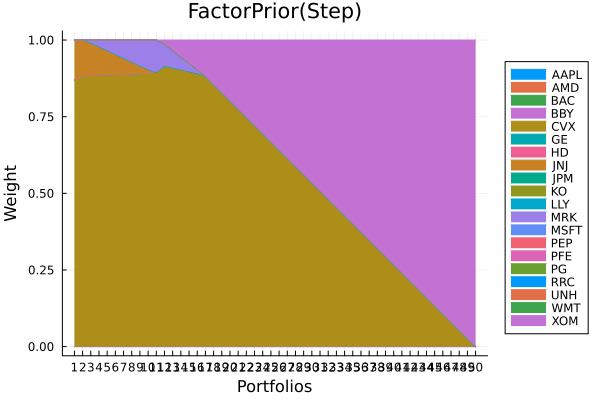

In [26]:
plot_stacked_area_composition(ress[2].w, rd.nx;
                              kwargs = (; xlabel = "Portfolios", ylabel = "Weight",
                                        title = "FactorPrior(Step)", legend = :outerright))

Factor prior frontier with stepwise regression.

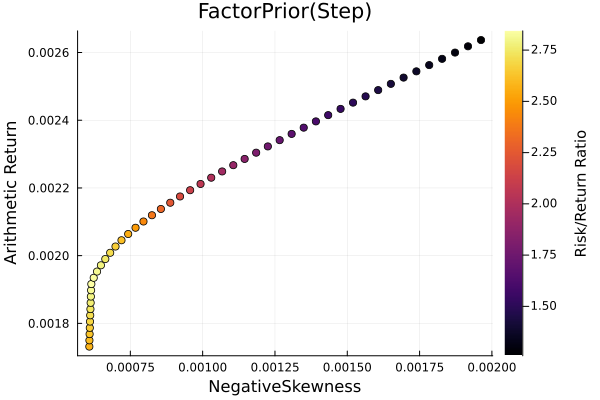

In [27]:
r = NegativeSkewness()
plot_measures(ress[2].w, prs[7]; x = r, y = ReturnRiskMeasure(; rt = ress[2].ret),
              c = ReturnRiskRatioRiskMeasure(; rt = ress[2].ret, rk = r,
                                             rf = 4.2 / 100 / 252),
              title = "FactorPrior(Step)", xlabel = "NegativeSkewness",
              ylabel = "Arithmetic Return", colorbar_title = "\nRisk/Return Ratio",
              right_margin = 6Plots.mm)

Factor prior using dimensionality reduction.

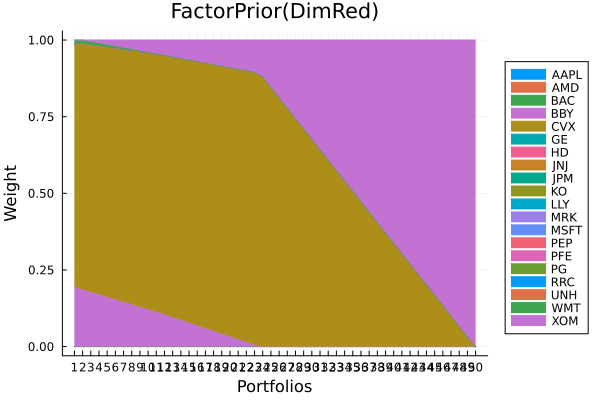

In [28]:
plot_stacked_area_composition(ress[3].w, rd.nx;
                              kwargs = (; xlabel = "Portfolios", ylabel = "Weight",
                                        title = "FactorPrior(DimRed)",
                                        legend = :outerright))

Factor prior frontier with stepwise regression.

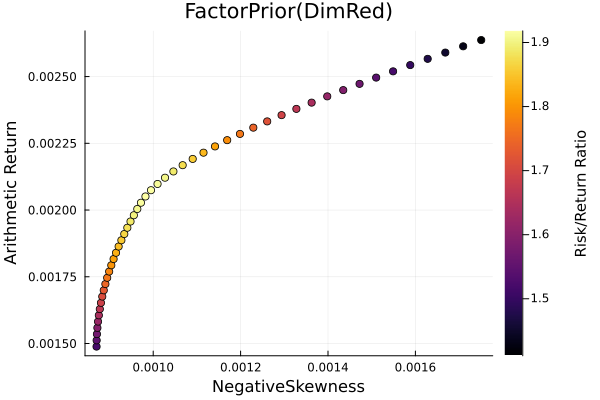

In [29]:
r = NegativeSkewness()
plot_measures(ress[3].w, prs[8]; x = r, y = ReturnRiskMeasure(; rt = ress[3].ret),
              c = ReturnRiskRatioRiskMeasure(; rt = ress[3].ret, rk = r,
                                             rf = 4.2 / 100 / 252),
              title = "FactorPrior(DimRed)", xlabel = "NegativeSkewness",
              ylabel = "Arithmetic Return", colorbar_title = "\nRisk/Return Ratio",
              right_margin = 6Plots.mm)

Let's optimise the maximum risk-adjusted return ratio of the three to see how a single portfolio differs.

In [30]:
opts = [JuMPOptimiser(; pr = prs[4], slv = slv), JuMPOptimiser(; pr = prs[7], slv = slv),
        JuMPOptimiser(; pr = prs[8], slv = slv)]

# Mean-Risk estimators using the standard deviation.
mrs = [MeanRisk(; r = NegativeSkewness(), obj = MaximumRatio(; rf = 4.2 / 100 / 252),
                opt = opt) for opt in opts]

# Optimise
ress = optimise.(mrs)
pretty_table(DataFrame("Assets" => rd.nx, "EmpiricalPrior" => ress[1].w,
                       "FactorPrior(Step)" => ress[2].w,
                       "FactorPrior(DimRed)" => ress[3].w); formatters = [resfmt])

┌────────┬────────────────┬───────────────────┬─────────────────────┐
│ Assets │ EmpiricalPrior │ FactorPrior(Step) │ FactorPrior(DimRed) │
│ String │        Float64 │           Float64 │             Float64 │
├────────┼────────────────┼───────────────────┼─────────────────────┤
│   AAPL │          0.0 % │             0.0 % │               0.0 % │
│    AMD │          0.0 % │             0.0 % │               0.0 % │
│    BAC │          0.0 % │             0.0 % │               0.0 % │
│    BBY │          0.0 % │             0.0 % │               0.0 % │
│    CVX │          0.0 % │          91.045 % │            83.707 % │
│     GE │          0.0 % │             0.0 % │               0.0 % │
│     HD │          0.0 % │             0.0 % │               0.0 % │
│    JNJ │          0.0 % │             0.0 % │               0.0 % │
│    JPM │          0.0 % │             0.0 % │               0.0 % │
│     KO │          0.0 % │             0.0 % │               0.0 % │
│    LLY │       25.

Here we have the opposite effect to before, this follows from the fact that for this particular scenario the condition number of the matrix of negative spectral slices of the coskewness is actually lower for the empirical prior than for the factor priors. This goes to show that higher order moments are more susceptible to noise, and factor models may not be able to fully mitigate this.

### 3.3 Mean-Kurtosis optimisation

Again we will do the same as before but with the kurtosis.

In [31]:
# JuMP Optimsiers, we will compute the efficient frontier with 50 points for all of them.
opts = [JuMPOptimiser(; pr = prs[4], slv = slv,
                      ret = ArithmeticReturn(; lb = Frontier(; N = 50))),
        JuMPOptimiser(; pr = prs[7], slv = slv,
                      ret = ArithmeticReturn(; lb = Frontier(; N = 50))),
        JuMPOptimiser(; pr = prs[8], slv = slv,
                      ret = ArithmeticReturn(; lb = Frontier(; N = 50)))]

# Mean-Risk estimators using the standard deviation.
mrs = [MeanRisk(; r = Kurtosis(), obj = MinimumRisk(), opt = opt) for opt in opts]

# Optimise
ress = optimise.(mrs)

3-element Vector{MeanRiskResult{DataType, T2, Vector{OptimisationReturnCode}, Vector{JuMPOptimisationSolution}, JuMP.Model, Nothing} where T2}:
 MeanRiskResult
       oe ┼ DataType: DataType
       pa ┼ ProcessedJuMPOptimiserAttributes
          │       pr ┼ HighOrderPrior
          │          │     pr ┼ LowOrderPrior
          │          │        │         X ┼ 252×20 Matrix{Float64}
          │          │        │        mu ┼ 20-element Vector{Float64}
          │          │        │     sigma ┼ 20×20 Matrix{Float64}
          │          │        │      chol ┼ nothing
          │          │        │         w ┼ nothing
          │          │        │       ens ┼ nothing
          │          │        │       kld ┼ nothing
          │          │        │        ow ┼ nothing
          │          │        │        rr ┼ nothing
          │          │        │      f_mu ┼ nothing
          │          │        │   f_sigma ┼ nothing
          │          │        │       f_w ┴ nothing
        

Let's plot the efficient frontiers. However, this time when plotting the frontiers we will use the prior returns because the kurtosis risk measure is not computed from the cokurtosis matrix, but from the returns directly.
Empirical prior composition.

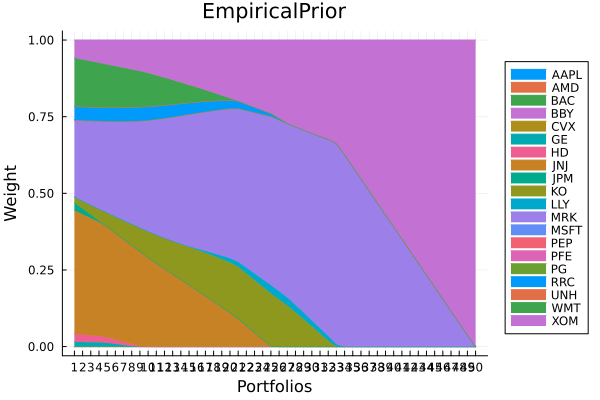

In [32]:
plot_stacked_area_composition(ress[1].w, rd.nx;
                              kwargs = (; xlabel = "Portfolios", ylabel = "Weight",
                                        title = "EmpiricalPrior", legend = :outerright))

Empirical prior frontier.

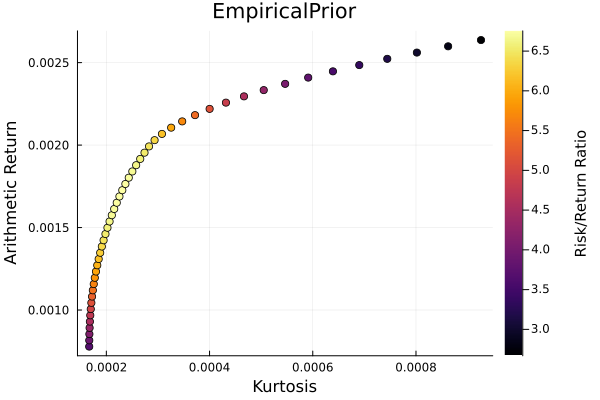

In [33]:
r = Kurtosis()
plot_measures(ress[1].w, prs[4]; x = r, y = ReturnRiskMeasure(; rt = ress[1].ret),
              c = ReturnRiskRatioRiskMeasure(; rt = ress[1].ret, rk = r,
                                             rf = 4.2 / 100 / 252),
              title = "EmpiricalPrior", xlabel = "Kurtosis", ylabel = "Arithmetic Return",
              colorbar_title = "\nRisk/Return Ratio", right_margin = 6Plots.mm)

Factor prior composition with stepwise regression.

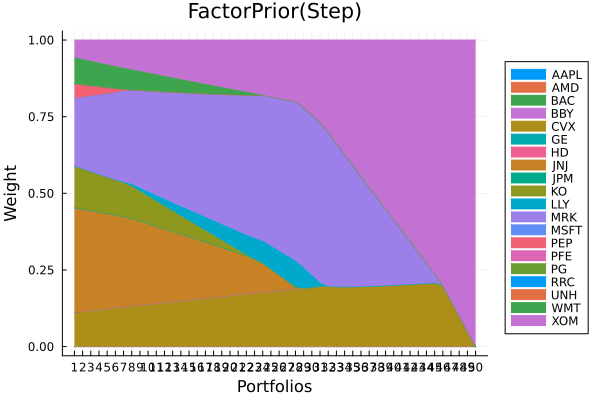

In [34]:
plot_stacked_area_composition(ress[2].w, rd.nx;
                              kwargs = (; xlabel = "Portfolios", ylabel = "Weight",
                                        title = "FactorPrior(Step)", legend = :outerright))

Factor prior frontier with stepwise regression.

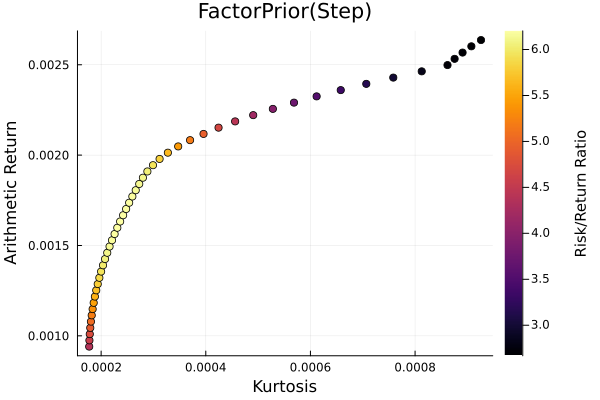

In [35]:
r = Kurtosis()
plot_measures(ress[2].w, prs[4]; x = r, y = ReturnRiskMeasure(; rt = ress[2].ret),
              c = ReturnRiskRatioRiskMeasure(; rt = ress[2].ret, rk = r,
                                             rf = 4.2 / 100 / 252),
              title = "FactorPrior(Step)", xlabel = "Kurtosis",
              ylabel = "Arithmetic Return", colorbar_title = "\nRisk/Return Ratio",
              right_margin = 6Plots.mm)

Factor prior using dimensionality reduction.

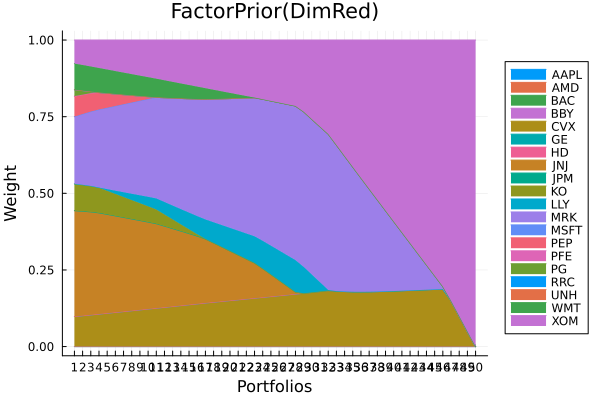

In [36]:
plot_stacked_area_composition(ress[3].w, rd.nx;
                              kwargs = (; xlabel = "Portfolios", ylabel = "Weight",
                                        title = "FactorPrior(DimRed)",
                                        legend = :outerright))

Factor prior frontier with stepwise regression.

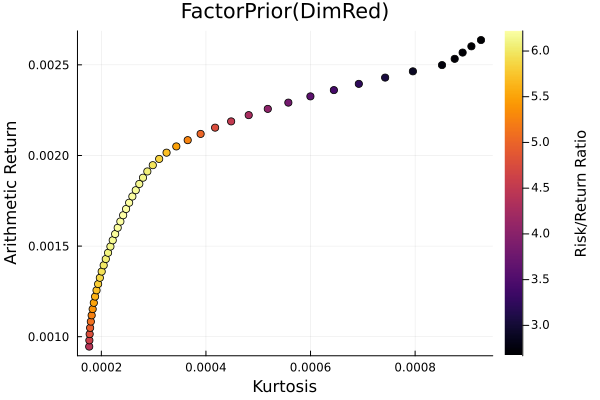

In [37]:
r = Kurtosis()
plot_measures(ress[3].w, prs[4]; x = r, y = ReturnRiskMeasure(; rt = ress[3].ret),
              c = ReturnRiskRatioRiskMeasure(; rt = ress[3].ret, rk = r,
                                             rf = 4.2 / 100 / 252),
              title = "FactorPrior(DimRed)", xlabel = "Kurtosis",
              ylabel = "Arithmetic Return", colorbar_title = "\nRisk/Return Ratio",
              right_margin = 6Plots.mm)

Let's optimise the maximum risk-adjusted return ratio of the three to see how a single portfolio differs.

In [38]:
opts = [JuMPOptimiser(; pr = prs[4], slv = slv), JuMPOptimiser(; pr = prs[7], slv = slv),
        JuMPOptimiser(; pr = prs[8], slv = slv)]

# Mean-Risk estimators using the standard deviation.
mrs = [MeanRisk(; r = NegativeSkewness(), obj = MaximumRatio(; rf = 4.2 / 100 / 252),
                opt = opt) for opt in opts]

# Optimise
ress = optimise.(mrs)
pretty_table(DataFrame("Assets" => rd.nx, "EmpiricalPrior" => ress[1].w,
                       "FactorPrior(Step)" => ress[2].w,
                       "FactorPrior(DimRed)" => ress[3].w); formatters = [resfmt])

┌────────┬────────────────┬───────────────────┬─────────────────────┐
│ Assets │ EmpiricalPrior │ FactorPrior(Step) │ FactorPrior(DimRed) │
│ String │        Float64 │           Float64 │             Float64 │
├────────┼────────────────┼───────────────────┼─────────────────────┤
│   AAPL │          0.0 % │             0.0 % │               0.0 % │
│    AMD │          0.0 % │             0.0 % │               0.0 % │
│    BAC │          0.0 % │             0.0 % │               0.0 % │
│    BBY │          0.0 % │             0.0 % │               0.0 % │
│    CVX │          0.0 % │          91.045 % │            83.707 % │
│     GE │          0.0 % │             0.0 % │               0.0 % │
│     HD │          0.0 % │             0.0 % │               0.0 % │
│    JNJ │          0.0 % │             0.0 % │               0.0 % │
│    JPM │          0.0 % │             0.0 % │               0.0 % │
│     KO │          0.0 % │             0.0 % │               0.0 % │
│    LLY │       25.

These findings are again consistent with the previous result, and reflective of the higher condition numbers of the factor-based higher order statistics. The next example will explore ways of reducing the estimation error.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*